In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,Birch
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import silhouette_score

# Wczytanie danych

In [2]:

labels = pd.read_fwf("./UCI_HAR_Dataset/features.txt",header=None)
X_train = pd.read_fwf("./UCI_HAR_Dataset/train/X_train.txt",header=None)
X_train.columns = labels


y_train = pd.read_fwf("./UCI_HAR_Dataset/train/y_train.txt",header=None)
y_train = pd.Series(y_train[0])

X_test = pd.read_fwf("./UCI_HAR_Dataset/test/X_test.txt",header=None)
X_test.columns = labels

y_test = pd.read_fwf("./UCI_HAR_Dataset/test/y_test.txt",header=None)
y_test = pd.Series(y_test[0])

data = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])


In [3]:
proper = list()
for i in range(len(data.columns)):
    proper.append(data.columns[i][0])  
data.columns = proper

data.reset_index(inplace=True,drop=True)

## Ilość klastrów

Z etykiet wiemy że mamy 6 klastrów, ale sprawdźmy dla jakiej ilości klastrów metoda sillhoute da najlepszy wynik.

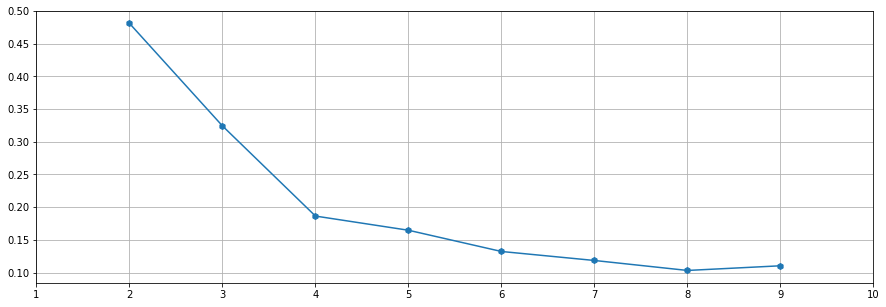

In [17]:
scors = []
for k in range(2, 10):
    met = KMeans(k)
    label = met.fit_predict(data)
    scors.append(silhouette_score(data,label))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), scors,marker='h')
plt.xticks(np.arange(1,11, 1))
plt.grid(True)



## Baseline

Jako punkt odniesniesienia do wszelkich następnych prób sprawdźmy jak poradzą sobie podstawowe algorytmy na nieprzekstałconym zbiorze danych.

In [31]:
kmean = KMeans(k)
yhat = kmean.fit_predict(data)
silhouette_score(data,yhat)

0.0694467809984462

In [32]:
ac = AgglomerativeClustering(k)
yhat = ac.fit_predict(data) 
silhouette_score(data,yhat)

0.05645208265480925

In [34]:
bir = Birch(n_clusters = k)
yhat = bir.fit_predict(data) 
silhouette_score(data,yhat)

0.05645208265480925

Jak widać wyniki osiągane przez algorytmy nie są najlepsze, czemu z pewnością nie sprzyaja szum tworzony przez sporą ilość kolumn, przez co cięzko o dobrze zdefiniowane klastry.

# Feature engineering

Biorąc pod uwagę z jak dużą ilościa kolumn mamy do czynienia nie ma mowy o ręcznym wybieraniu cech, musimy się posiłkować odpowiednimi algorytmami.

In [26]:
pca = PCA(n_components=100)
pca_data = pca.fit_transform(data)
cum_ratio = (np.cumsum(pca.explained_variance_ratio_))

variance_ratio = 0.80
variance = np.cumsum(pca.explained_variance_ratio_)
num = np.sum(variance<variance_ratio)+1
print(f'{variance_ratio} % wariancji jest przestawiane przez {num} zmiennych')

0.8 % wariancji jest przestawiane przez 11 zmiennych


In [12]:
pca = PCA(n_components=11)
pca_data = pca.fit_transform(data)

Text(0, 0.5, 'Sillhoute score')

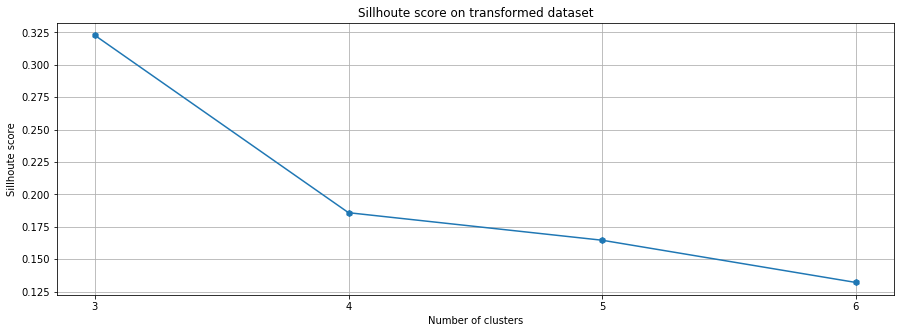

In [14]:
scors = []
for k in range(3,7):
    kmean = KMeans(k)
    yhat = kmean.fit_predict(pca_data)
    scors.append(silhouette_score(data,yhat))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(3, 7), scors,marker='h')
plt.xticks(np.arange(3,7,1))
plt.grid(True)
plt.title('Sillhoute score on PCA transformed dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Sillhoute score')

Całkiem dobry wynik dla k=3.

In [ ]:

pca = PCA(n_components=0.9, random_state=3)
pca_data = pca.fit_transform(data)

tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(pca_data)
scors = []
for k in range(3,7):
    kmean = KMeans(k)
    yhat = kmean.fit_predict(tsne_transformed)
    scors.append(silhouette_score(data,yhat))


Text(0, 0.5, 'Sillhoute score')

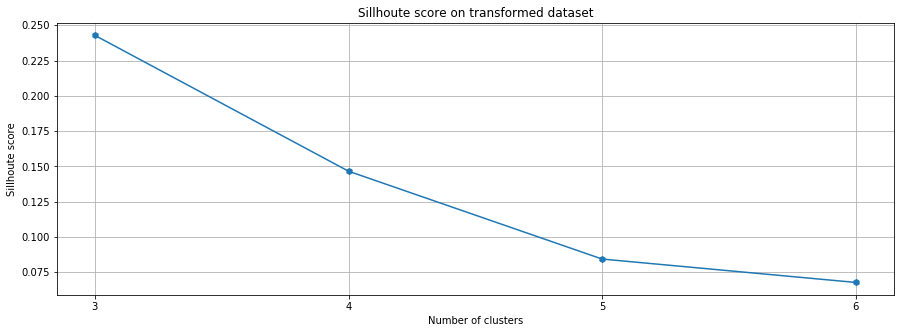

In [16]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(3, 7), scors,marker='h')
plt.xticks(np.arange(3,7,1))
plt.grid(True)
plt.title('Sillhoute score on Tsne transformed dataset')
plt.xlabel('Number of clusters')
plt.ylabel('Sillhoute score')


## Usuwanie zmiennych z niską wariancją

Kolejną metoda z której zdecydujemy się skorzystać będzie Variance Threshold

In [48]:
selector = VarianceThreshold(0.05)
X_new = selector.fit_transform(data)

In [49]:
kmean = KMeans(6)
yhat = kmean.fit_predict(X_new)
silhouette_score(data,yhat)

0.06027302691693993